In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import geopandas
import pandas
import pathlib
import numpy
import matplotlib.pyplot
import seaborn
import shapely
import rioxarray
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [14]:
resolution = 8
horizontal_crs = 2193

### Load in GeoFabrics Bathymetry estimates

In [15]:
cache_path = pathlib.Path(r"C:\Local\data\catchments\Westport\caches\NZ20_Westport")
folder = "paper"
dems = {}
dems["Unconditioned"] = rioxarray.rioxarray.open_rasterio(cache_path / folder  / "geofabric_8m_unconditioned.nc", masked=True).squeeze("band", drop=True)
dems["Wide uniform flow"] = rioxarray.rioxarray.open_rasterio(cache_path / folder  / "geofabric_8m_rupp_and_smart_wide.nc", masked=True).squeeze("band", drop=True)
dems["Wide conceptual multivariate regression"] = rioxarray.rioxarray.open_rasterio(cache_path / folder  / "geofabric_8m_neal_et_al_wide.nc", masked=True).squeeze("band", drop=True)
dems["Measured Sections"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_8m_measured_river.nc", masked=True).squeeze("band", drop=True)
dems["Riparian 1m Raw"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "wide_river" / "raw_veg_dem.nc", masked=True).squeeze("band", drop=True)
dems["Gnd 1m Raw"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "wide_river" / "raw_gnd_dem.nc", masked=True).squeeze("band", drop=True)

In [16]:
polygon = geopandas.read_file(cache_path / folder / "measured_river" / "river_polygon.geojson")
riverbanks = geopandas.read_file(pathlib.Path(r"C:\Local\data\catchments") / "measured_sections" / "westport" / "riverbanks.geojson")
normalised_distances = numpy.arange(0, riverbanks.length.max())/riverbanks.length.max()
riverbanks=riverbanks.apply(lambda row: row.geometry.interpolate(normalised_distances, normalized=True), axis=1)
river_centreline = geopandas.GeoDataFrame(geometry=[shapely.geometry.LineString([shapely.geometry.MultiPoint([right, left]).centroid for (right, left) in zip(riverbanks.loc[0], riverbanks.loc[1])])],
                                          crs=horizontal_crs)

## Load in sample cross sections & widths
See raw cell below for converting to NZVD2016. This has already been done so load in the converted one directly

In [17]:
sampled_sections = geopandas.read_file(cache_path / folder / "wide_river" / "final_cross_sections.geojson")
sampled_sections = sampled_sections.drop(columns=['min_z_centre', 'min_z_centre_unimodal', 'slope',
       'min_z_centre_unimodal_mean_0.05km', 'slope_mean_0.05km',
       'min_z_centre_unimodal_mean_0.25km', 'slope_mean_0.25km',
       'min_z_centre_unimodal_mean_0.5km', 'slope_mean_0.5km',
       'min_z_centre_unimodal_mean_1.0km', 'slope_mean_1.0km', 'widths',
       'threshold', 'channel_count', 'flat_widths', 'valid', 'valid_widths',
       'valid_flat_widths', 'valid_threhold', 'widths_mean_0.05km',
       'flat_widths_mean_0.05km', 'thresholds_mean_0.05km',
       'widths_mean_0.15km', 'flat_widths_mean_0.15km',
       'thresholds_mean_0.15km', 'widths_mean_0.2km', 'flat_widths_mean_0.2km',
       'thresholds_mean_0.2km', 'widths_mean_0.25km',
       'flat_widths_mean_0.25km', 'thresholds_mean_0.25km'])

In [18]:
widths = {}
widths["Wide"] = geopandas.read_file(cache_path / folder / "wide_river" / "final_widths.geojson")
widths["Narrow"] = geopandas.read_file(cache_path / folder / "narrow_river" / "final_widths.geojson")
thresholds = {"Narrow Min": 0.5, "Narrow Max": 0.75, "Wide Min": 2, "Wide Max": 5}

## Sample DEM for elevations
Record the Bias and STDev for each cross section against the two DEMS

<Axes: >

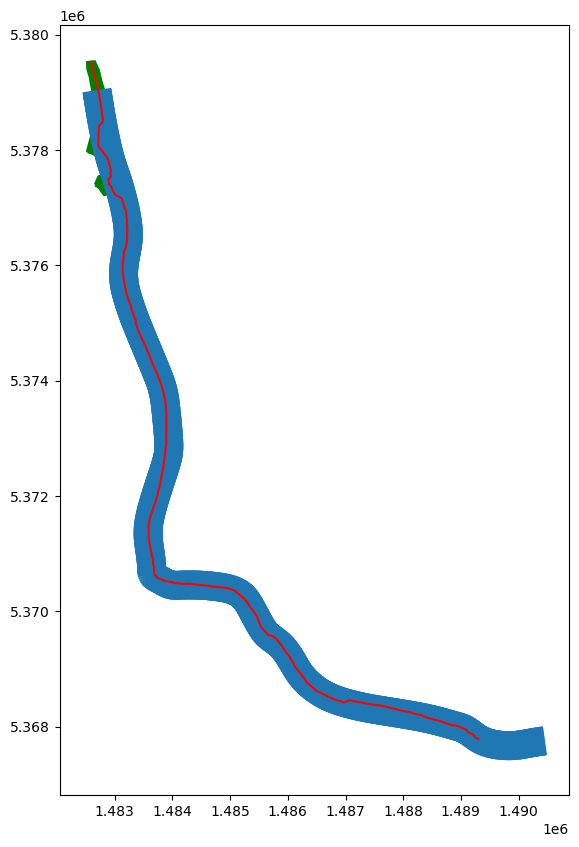

In [19]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(20, 10))
polygon.plot(ax=ax, color='g')
sampled_sections.plot(ax=ax)
river_centreline.plot(ax=ax, color='r')

# Sample every 1m
Use Linear interpolation in between

In [20]:
comparisons_sampled = {**dict((f"{key} z", []) for key in dems), **dict((f"{key} river", []) for key in widths), **{"Section": [], "Polygon": [], "Distance Upstream [m]": [], "Offset [m]": []}}
intersection_points = sampled_sections.intersection(river_centreline.iloc[0].geometry)
sampled_sections = sampled_sections[intersection_points.is_empty==False]
intersection_points = intersection_points[intersection_points.is_empty==False]
for index, row in sampled_sections.iterrows():
    print(f"Section number = {index} of {len(sampled_sections)}")
    line = row.geometry
    distance_upstream = float(river_centreline.project(intersection_points.iloc[index]))
    for offset in list(range(int(numpy.ceil(line.length)))):
        point = line.interpolate(offset)
        for key in dems:
            comparisons_sampled[f"{key} z"].append(float(dems[key].z.interp(x=point.x, y=point.y)))
        for key in widths:
            if widths[key].iloc[index].geometry is not None:
                comparisons_sampled[f"{key} river"].append(widths[key].iloc[index].geometry.distance(point) < 0.001)
            else:
                comparisons_sampled[f"{key} river"].append(False)
        comparisons_sampled["Section"].append(index)
        comparisons_sampled["Polygon"].append(polygon.iloc[0].geometry.contains(point))
        comparisons_sampled["Distance Upstream [m]"].append(distance_upstream)
        comparisons_sampled["Offset [m]"].append(offset)
    if index > 10:
        break
comparisons_sampled = pandas.DataFrame.from_dict(comparisons_sampled)

C:\Users\pearsonra\Anaconda3\envs\raster\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Section number = 0 of 1537
Section number = 1 of 1537
Section number = 2 of 1537
Section number = 3 of 1537
Section number = 4 of 1537
Section number = 5 of 1537
Section number = 6 of 1537
Section number = 7 of 1537
Section number = 8 of 1537
Section number = 9 of 1537
Section number = 10 of 1537
Section number = 11 of 1537


In [23]:
comparisons_sampled.to_json(cache_path / folder / "sampled_section_comparison" / "sampled_values.json")

# Plot sampled elevations along entire sections
Plot the sampled elevations along individual cross-sections including the on-land portions as a sanity check.

In [24]:
columns = [f"{key} z" for key in dems]
for section in comparisons_sampled['Section'].unique():
    # Plot the samppled profiles
    distance = comparisons_sampled[comparisons_sampled['Section']==section]['Distance Upstream [m]'].iloc[0]
    
    # Plot sampled DEMs elevations
    axis = comparisons_sampled[comparisons_sampled["Section"]==section][columns].plot(title=f"{distance}m upstream", figsize=(15,10), linewidth=3)
    
    # Add doted lines showing where the 'water' was detected - note should all be viewed on the unconditioend DEM
    for river_name in widths:
        for dem_name in dems:
            if river_name in dem_name:
                 comparisons_sampled[(comparisons_sampled["Section"]==section) & (comparisons_sampled[f"{river_name} river"]==True)][[f"{dem_name} z"]].plot(ax=axis, linestyle=':', linewidth=4);
    
    # Plot the z_water and thresholds
    matplotlib.pyplot.axhline(y=sampled_sections.iloc[section]["min_z_water"], color='r', linestyle=':', label="min_z_water")
    for threshold_name in thresholds:
        matplotlib.pyplot.axhline(y=sampled_sections.iloc[section]["min_z_water"] + thresholds[threshold_name], color=numpy.random.rand(3,), linestyle=':', label=threshold_name)
    matplotlib.pyplot.legend()
    axis.figure.savefig(cache_path / folder / "sampled_section_comparison" / f"{distance}m_upstream.png")
    matplotlib.pyplot.close()

# Todo -
1. read in i_start & i_end
2. note if not valid in plot